In [169]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
import glob
from reorder import reorder_coords

import numpy as np
from scipy.interpolate import splprep, splev, BSpline

In [170]:
def read_2d_slice_data(fname):
    # Read in 2D data
    file_path = fname
    with open(file_path, 'r') as f:
        s = f.readlines()
    
    # Extract 2D surface data
    for i, line in enumerate(s):
        if line.strip().startswith('DATAPACKING=POINT'):
            nnod = int(s[i-1].split('=')[1].split()[0].split(',')[0])
            nelm = int(s[i-1].split('=')[2].split()[0].split(',')[0])
    
            d2_dat = s[i+1:i+1+nnod]
            
            d2_dat = np.genfromtxt(d2_dat, dtype=float)
    
            break
    
    d2_df = pd.DataFrame(d2_dat[:,[0,1,2,6,7,8,9]], columns=['CoordinateX', 'CoordinateY', 'CoordinateZ', 'VX', 'VY', 'VZ', 'CP'])
    
    connectivity = np.genfromtxt(s[i+1+nnod:], dtype=float)
    df_conn = pd.DataFrame(connectivity, columns=['NodeC1', 'NodeC2'])
    
    result = pd.concat([d2_df, df_conn], axis=1)
    d2_df = result.reindex(d2_df.index)
    
    index_list = list(reorder_coords(d2_df, return_indices=True))
    d2_df = d2_df.loc[index_list]

    return d2_df

In [171]:
def closest_point(x, y, xtarget, ytarget):
    xy = np.concatenate((x.reshape(-1,1), y.reshape(-1,1)), axis=1)
    xy_target = np.ones(xy.shape) @ np.diag([xtarget, ytarget])

    d = np.sqrt(np.sum((xy - xy_target)**2, axis=1))

    return np.argmin(d)

def fit_raw_Bspline(df):
    ''' Fit B-Spline to parameterized curve and find point of maximum curvature '''
    x, y = df['CoordinateX'].values, df['CoordinateY'].values
    tck, _ = splprep([x, y], s=0, k=3)

    # Assumption: s=0.7 encompasses point of maximum curvature
    u = np.linspace(0., 0.7, 1000)
    new_points = splev(u, tck)
    derivs = splev(u, tck, der=2)

    ind_sort = np.argsort(derivs[1])[::-1]
    for i in ind_sort:
        if new_points[0][i]>0.5:
            imax = i
            xtip, ytip = new_points[0][imax], new_points[1][imax]
            break

    # Fit entire wing surface
    s = np.linspace(0., 1.0, 1000)
    new_points = splev(s, tck)
    xspline, yspline = new_points[0], new_points[1]

    # Get corrdinate index closest to B-spline tip
    imin = closest_point(x, y, xtip, ytip)
    xtip, ytip = x[imin], y[imin]

    return xspline, yspline, s, xtip, ytip

def rotate_scale(x, y, xtip, ytip):
     # Rotate
    t = np.arctan(ytip/xtip)
    R = np.array([[np.cos(t), -np.sin(t)], [np.sin(t), np.cos(t)]])
    xy = np.concatenate((x.reshape(-1,1), y.reshape(-1,1)), axis=1)
    xy = xy @ R
    x, y = xy[:,0], xy[:,1]
    xytip = np.array([[xtip, ytip]]) @ R
    xtip, ytip = xytip[0,0], xytip[0,1]

    # Scale volume
    V = np.array([[1/xtip, 0],[0, 1/xtip]])
    xy = np.concatenate((x.reshape(-1,1), y.reshape(-1,1)), axis=1)
    xy = xy @ V
    x, y = xy[:,0], xy[:,1]
    xytip = np.array([[xtip, ytip]]) @ V
    xtip, ytip = xytip[0,0], xytip[0,1]

    return x, y, xtip, ytip

def fit_processed_Bspline(x, y, ns=int(1e5)):
    ''' Fit B-Spline to processed data '''
    tck, _ = splprep([x, y], s=0, k=3)

    # Fit entire wing surface
    s = np.linspace(0., 1.0, int(1e5))
    new_points = splev(s, tck)
    xspline, yspline = new_points[0], new_points[1]

    return xspline, yspline, s, tck

In [135]:
def parameterize_airfoil_curve(df, ns=100):
    # Fit raw data to B-Splines
    x, y = df['CoordinateX'].values, df['CoordinateY'].values
    xspline, yspline, s, xtip, ytip = fit_raw_Bspline(df)
    x, y, xtip, ytip = rotate_scale(x, y, xtip, ytip)

    # Fit B-Spline to processed coordinate data
    xspline, yspline, s, tck = fit_processed_Bspline(x, y)
    xyspline = np.concatenate((xspline.reshape(-1,1), yspline.reshape(-1,1)), axis=1)

    # Get spline interpolation point falling closest to trailing tip of original data
    i = closest_point(xspline, yspline, xtip, ytip)
    midpoint = splev(np.array(s[i]), tck)
    xy = np.concatenate((x.reshape(-1,1), y.reshape(-1,1)), axis=1)
    
    # sample spline along top and bottom
    sbottom = np.linspace(0, s[i], ns)
    stop = np.linspace(s[i], 1., ns)
    xspline_b, yspline_b = splev(sbottom, tck)
    xspline_t, yspline_t = splev(stop, tck)
    
    xyspline_b = np.concatenate((xspline_b.reshape(-1,1), yspline_b.reshape(-1,1)), axis=1)
    xyspline_t = np.concatenate((xspline_t.reshape(-1,1), yspline_t.reshape(-1,1)), axis=1)

    return xyspline, xyspline_b, xyspline_t, s, sbottom, stop, midpoint, xy, xtip, ytip

def calculate_data_distance(df1, df2):
    _, xys_b_1, xys_t_1, _, _, _, _, _, _, _ = parameterize_airfoil_curve(df1)
    _, xys_b_2, xys_t_2, _, _, _, _, _, _, _ = parameterize_airfoil_curve(df2)
    
    dist_b = np.sum(np.sqrt(np.sum((xys_b_1 - xys_b_2)**2, axis=1)))
    dist_t = np.sum(np.sqrt(np.sum((xys_t_1 - xys_t_2)**2, axis=1)))
    dist = dist_b + dist_t

    return dist

In [136]:
data_dir = 'data/2D/'
files = glob.glob(data_dir+'*_slices.dat')
dataframes = []

for fname in files:
    df = read_2d_slice_data(fname)
    # Shift leading edge
    df['CoordinateX'] = df['CoordinateX'] - df['CoordinateX'].values[0]
    df['CoordinateY'] = df['CoordinateY'] - df['CoordinateY'].values[0]
    dataframes.append(df)

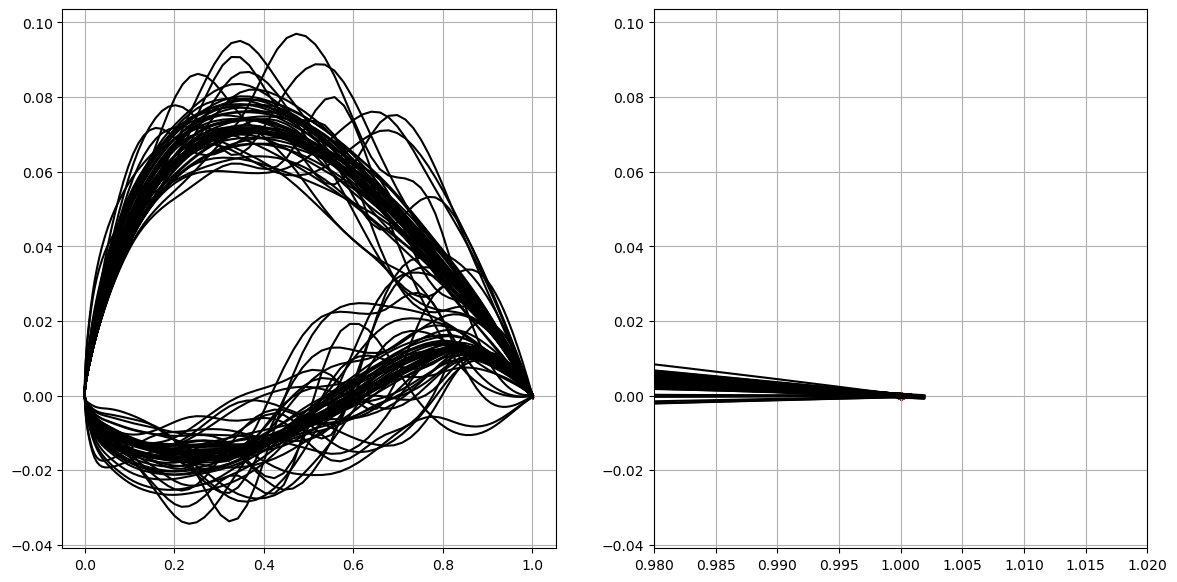

In [137]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,7))

for df in dataframes:
    xyspline, xyspline_b, xyspline_t, s, sbottom, stop, midpoint, xy, xtip, ytip = parameterize_airfoil_curve(df)
    x, y = xy[:,0], xy[:,1]

    axs[0].plot(x, y, c='k')
    axs[0].scatter(xtip, ytip, c='r', s=2)

    axs[1].plot(x, y, c='k')
    axs[1].scatter(xtip, ytip, c='r', s=20)
    axs[1].set_xlim(0.98, 1.02)


axs[0].grid()
axs[1].grid()
#ax.set_aspect('equal')
plt.show()

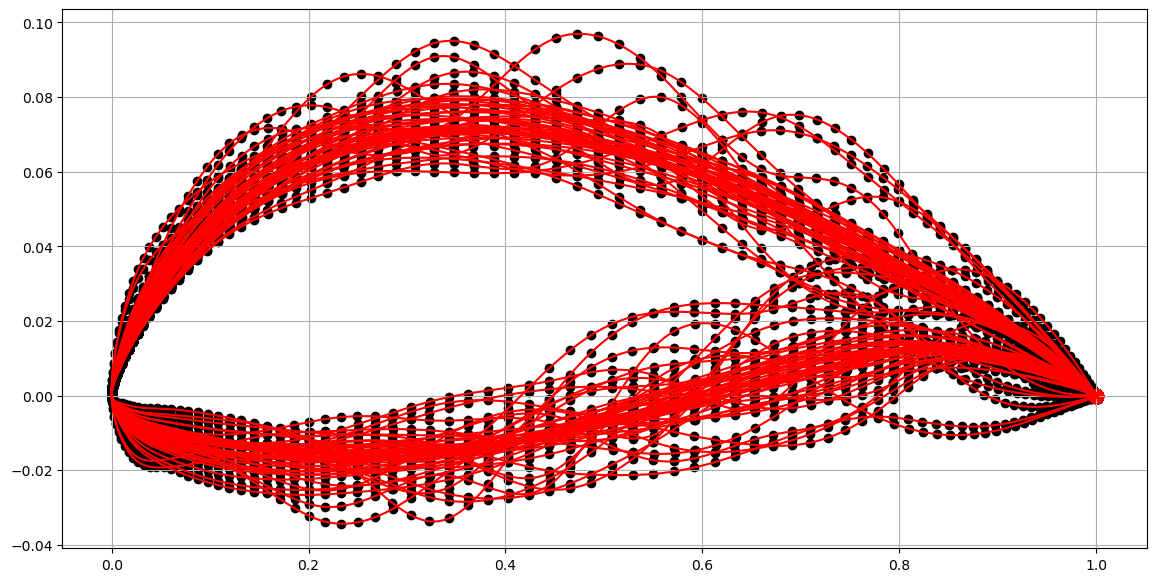

In [138]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(14,7))

for df in dataframes:
    xyspline, xyspline_b, xyspline_t, s, sbottom, stop, midpoint, xy, xtip, ytip = parameterize_airfoil_curve(df)

    ax.scatter(xy[:,0], xy[:,1], c='k')
    ax.plot(xyspline[:,0], xyspline[:,1], c='r')
    ax.scatter(midpoint[0], midpoint[1], c='r', s=100)

ax.grid()
#ax.set_aspect('equal')
plt.show()

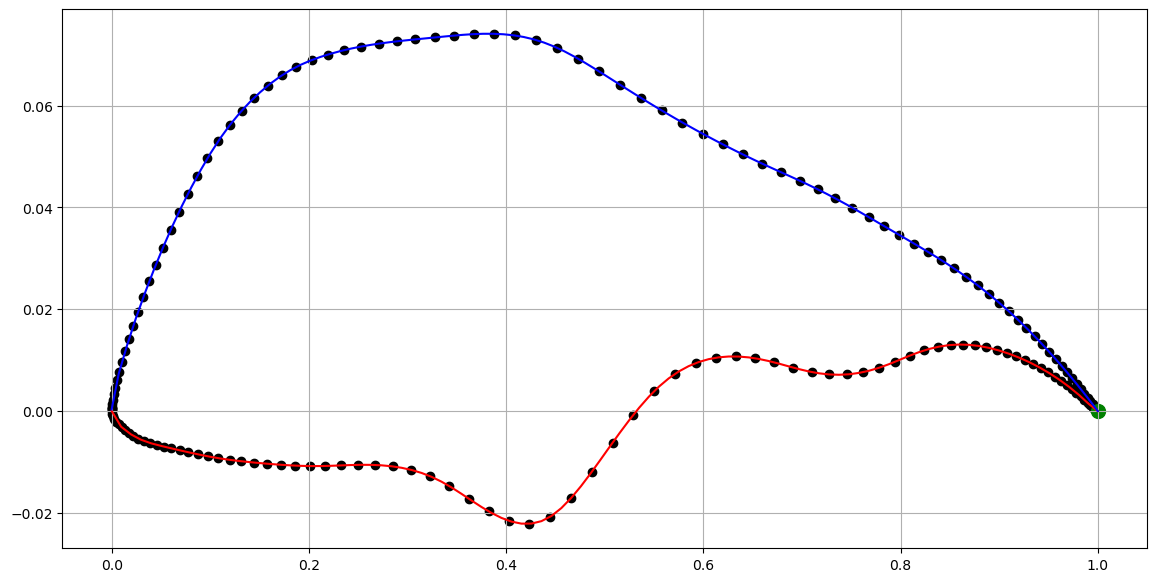

In [168]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(14,7))

df1 = dataframes[0]
xyspline, xyspline_b, xyspline_t, s, sbottom, stop, m, xy, xtip, ytip = parameterize_airfoil_curve(df1)

ax.scatter(xy[:,0], xy[:,1], c='k')
ax.plot(xyspline_b[:,0], xyspline_b[:,1], 'r')
ax.plot(xyspline_t[:,0], xyspline_t[:,1], 'b')
#ax.plot(xspline, yspline, c='r')
ax.scatter(m[0], m[1], c='g', s=100)

ax.grid()
#ax.set_aspect('equal')

plt.savefig('single_geometry')

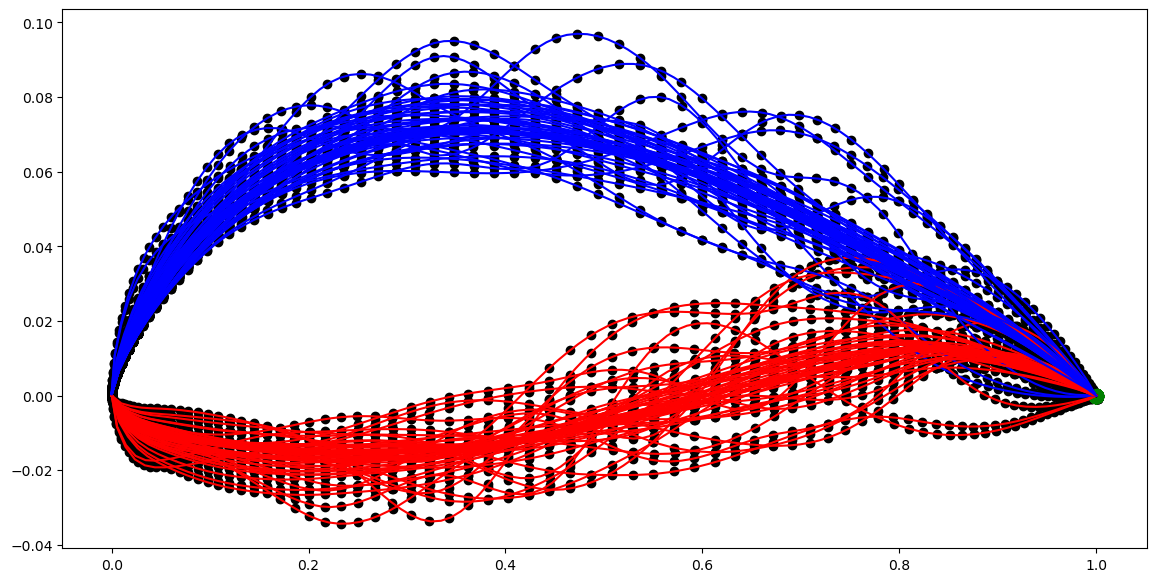

In [143]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(14,7))

min_dist = 1e+12
max_dist = -1e+12

distances = [0.0]

# Target DataFrame
df1 = dataframes[0]
xyspline, xyspline_b, xyspline_t, s, sbottom, stop, m, xy, xtip, ytip = parameterize_airfoil_curve(df1)
# Plot target df
ax.scatter(xy[:,0], xy[:,1], c='k')
ax.plot(xyspline_b[:,0], xyspline_b[:,1], 'r')
ax.plot(xyspline_t[:,0], xyspline_t[:,1], 'b')
ax.scatter(m[0], m[1], c='g', s=100)

for df in dataframes[1:]:
    xyspline, xyspline_b, xyspline_t, s, sbottom, stop, m, xy, xtip, ytip = parameterize_airfoil_curve(df)

    # Plot current df
    ax.scatter(xy[:,0], xy[:,1], c='k')
    ax.plot(xyspline_b[:,0], xyspline_b[:,1], 'r')
    ax.plot(xyspline_t[:,0], xyspline_t[:,1], 'b')
    ax.scatter(m[0], m[1], c='g', s=100)

    dist = calculate_data_distance(df1, df)
    distances.append(dist)
    
    if dist< min_dist:
        min_dist = dist
        min_df = df

    if dist> max_dist:
        max_dist = dist
        max_df = df


In [145]:
distance_index = np.argsort(distances)

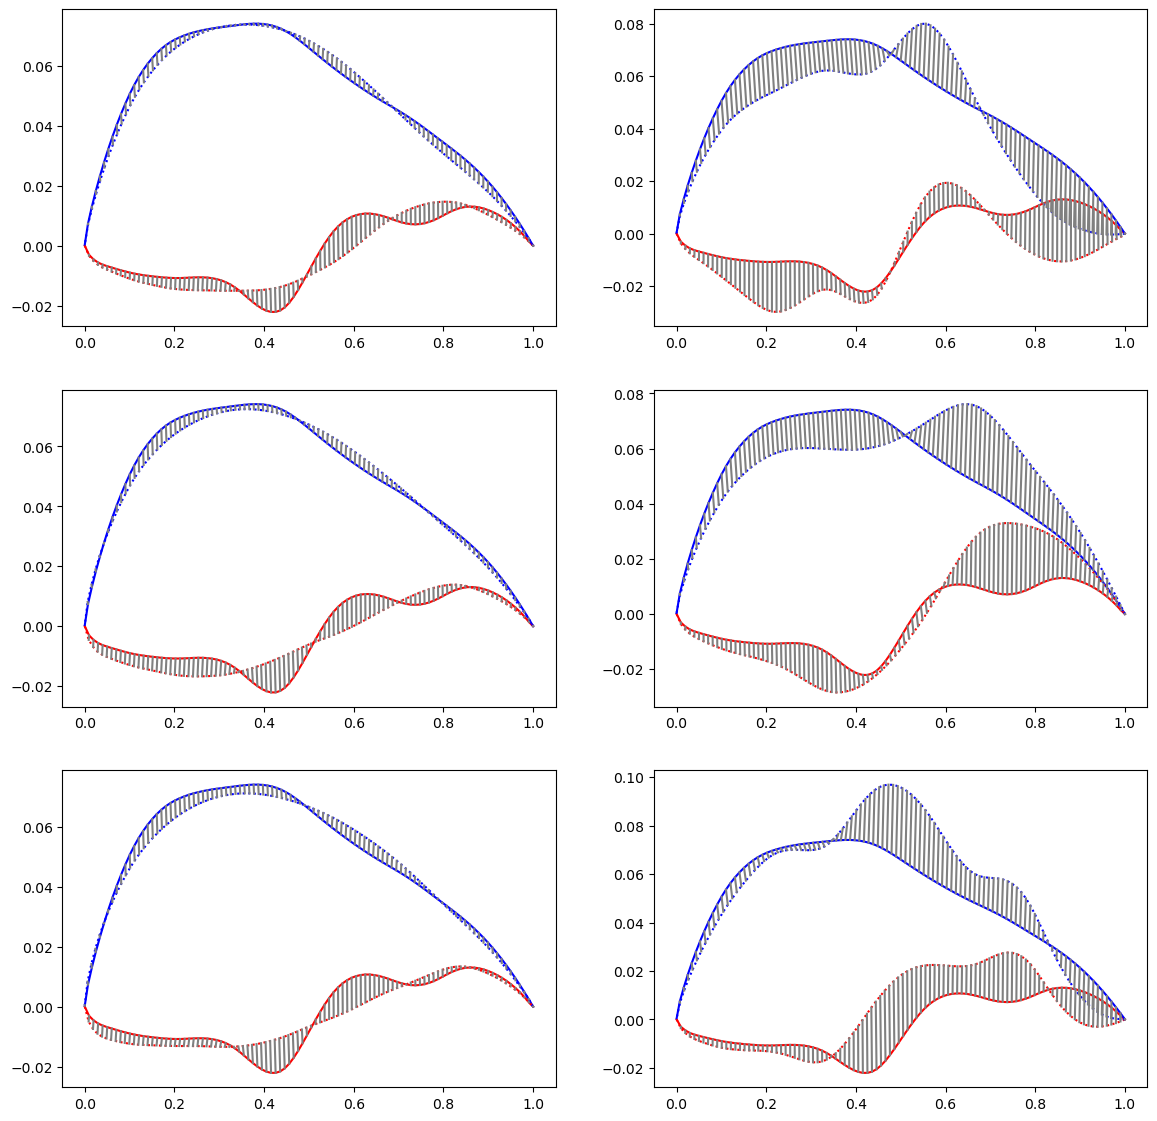

In [165]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(14,14))

df1 = dataframes[0]
xyspline, xyspline_b, xyspline_t, s, sbottom, stop, m, xy, xtip, ytip = parameterize_airfoil_curve(df1)
for i in range(3):
    for j in range(2):
        ax = axs[i,j]
        # Plot target df
        ax.plot(xyspline_b[:,0], xyspline_b[:,1], 'r')
        ax.plot(xyspline_t[:,0], xyspline_t[:,1], 'b')

for i in range(3):
    ax = axs[i,0]
    df = dataframes[distance_index[i+1]]
    xyspline, xyspline_b, xyspline_t, s, sbottom, stop, m, xy, xtip, ytip = parameterize_airfoil_curve(df)
    
    # Plot current df
    ax.plot(xyspline_b[:,0], xyspline_b[:,1], 'r', linestyle='dotted')
    ax.plot(xyspline_t[:,0], xyspline_t[:,1], 'b', linestyle='dotted')

for i in range(3):
    ax = axs[i,1]
    df = dataframes[distance_index[len(distance_index)-(i+1)]]
    xyspline, xyspline_b, xyspline_t, s, sbottom, stop, m, xy, xtip, ytip = parameterize_airfoil_curve(df)
    
    # Plot current df
    ax.plot(xyspline_b[:,0], xyspline_b[:,1], 'r', linestyle='dotted')
    ax.plot(xyspline_t[:,0], xyspline_t[:,1], 'b', linestyle='dotted')


for i in range(3):
    ax = axs[i,0]
    df = dataframes[distance_index[i+1]]
    _, xyspline_b_1, xyspline_t_1, _, _, _, _, _, _, _ = parameterize_airfoil_curve(df1)
    _, xyspline_b, xyspline_t, _, _, _, _, _, _, _ = parameterize_airfoil_curve(df)
    for i in range(ns):
        ax.plot([xyspline_b[i,0], xyspline_b_1[i,0]], [xyspline_b[i,1], xyspline_b_1[i,1]], c='grey')
        ax.plot([xyspline_t[i,0], xyspline_t_1[i,0]], [xyspline_t[i,1], xyspline_t_1[i,1]], c='grey')

for i in range(3):
    ax = axs[i,1]
    df = dataframes[distance_index[len(distance_index)-(i+1)]]
    _, xyspline_b_1, xyspline_t_1, _, _, _, _, _, _, _ = parameterize_airfoil_curve(df1)
    _, xyspline_b, xyspline_t, _, _, _, _, _, _, _ = parameterize_airfoil_curve(df)
    for i in range(ns):
        ax.plot([xyspline_b[i,0], xyspline_b_1[i,0]], [xyspline_b[i,1], xyspline_b_1[i,1]], c='grey')
        ax.plot([xyspline_t[i,0], xyspline_t_1[i,0]], [xyspline_t[i,1], xyspline_t_1[i,1]], c='grey')

plt.savefig('geometry_comparison')
    

In [76]:
print(min_dist)

6.266219038413146
